In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [2]:
ts_data = pd.read_csv('../data/it-data-4metrics.csv', sep=',')
dnn_data = pd.read_csv('DNN_id2.csv')

# Delete the useless columns
ts_data = ts_data.iloc[:,0:4]
ts_data.head()

,metric_id,timestamp,value,metric_name
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used


In [3]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in ts_data.index:
    if ts_data['metric_name'][indx] not in dic_name.keys():
        dic_name[ts_data['metric_name'][indx]] = []
    if ts_data['metric_id'][indx] not in dic_name[ts_data['metric_name'][indx]]:
        dic_name[ts_data['metric_name'][indx]].append(ts_data['metric_id'][indx])
        dic_id[ts_data['metric_id'][indx]] = [ts_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

In [4]:
dicOpt = {}
for indx_name in keys_name:
    tmp = float('inf')
    indexOpt = 0
    for indx in dic_name[indx_name]:
        indexNames = dnn_data[ dnn_data['metric_id'] == indx ].index
        valeur = dnn_data.loc[indexNames, 'mean_squared_error'].values
        if 1 < valeur[0] < tmp:
            tmp, indexOpt = valeur[0], indexNames
    if indexOpt == 0:
        tmp = float('inf')
        indexOpt = 0
        for indx in dic_name[indx_name]:
            indexNames = dnn_data[ dnn_data['metric_id'] == indx ].index
            valeur = dnn_data.loc[indexNames, 'mean_squared_error'].values
            if 0 < valeur[0] < tmp:
                tmp, indexOpt = valeur[0], indexNames
    dicOpt[indx_name] = indexOpt

cpu_prct_used


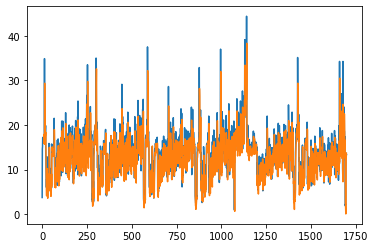

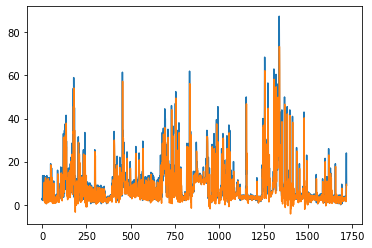

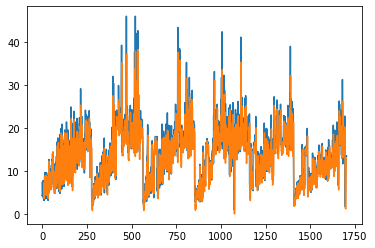

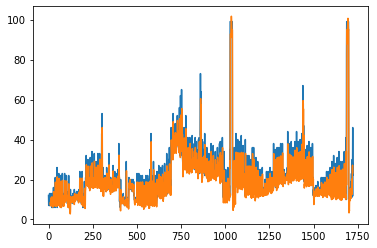

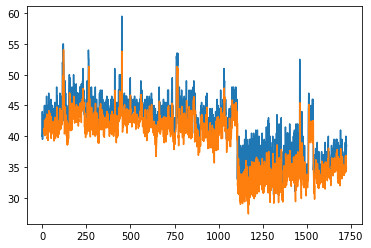

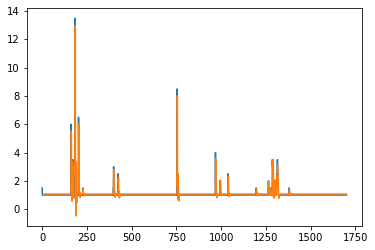

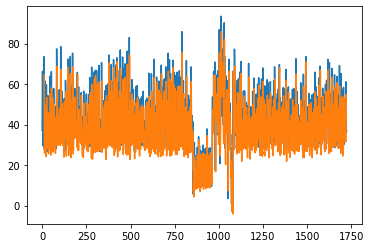

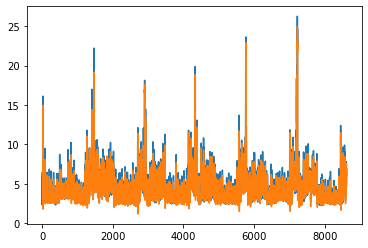

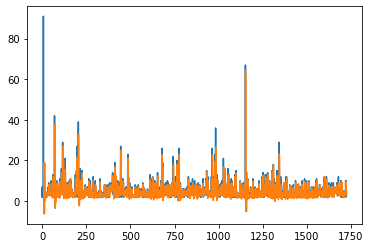

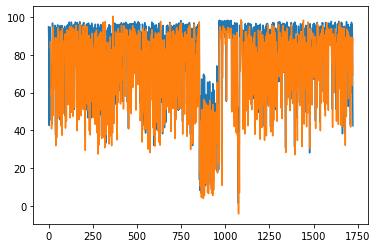

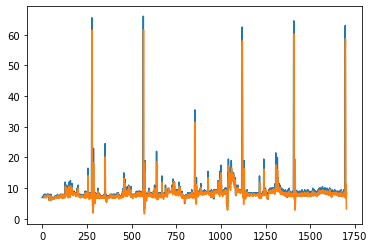

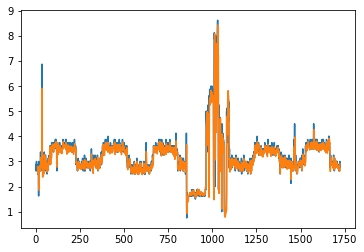

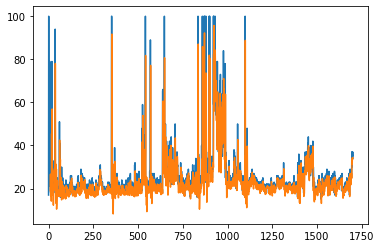

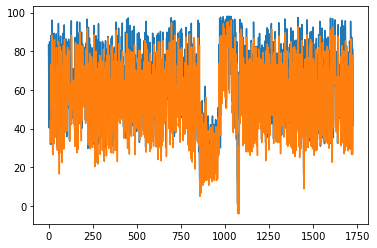

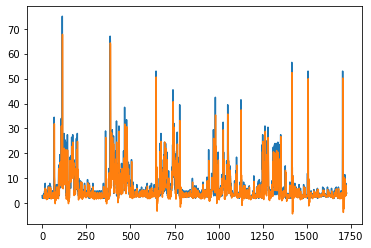

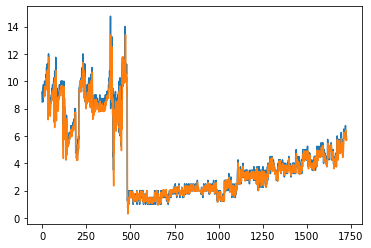

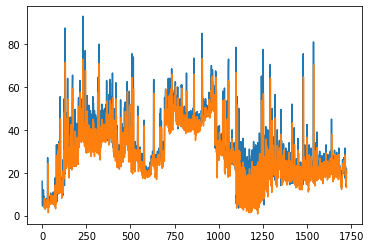

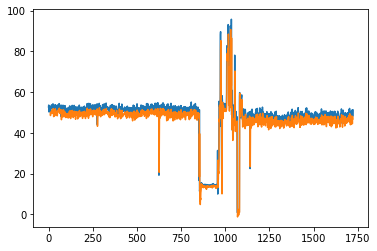

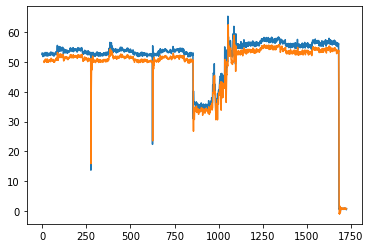

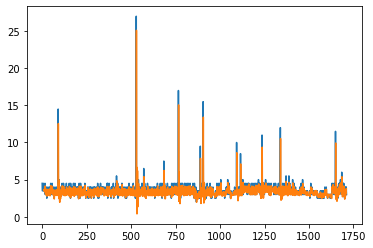

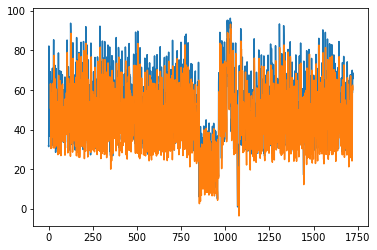

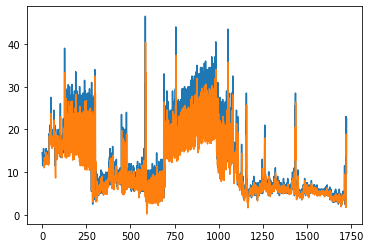

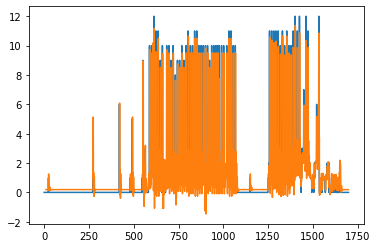

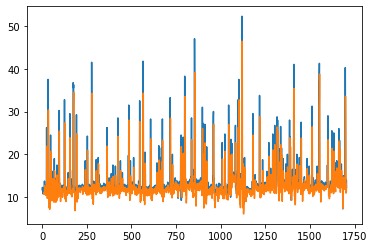

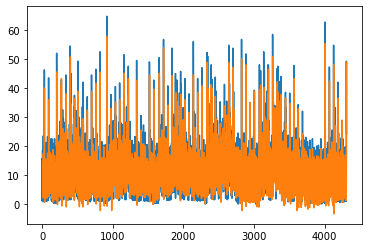

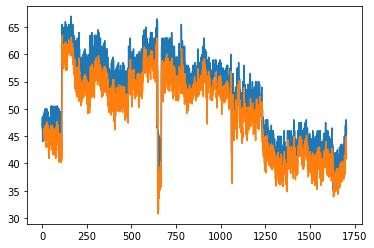

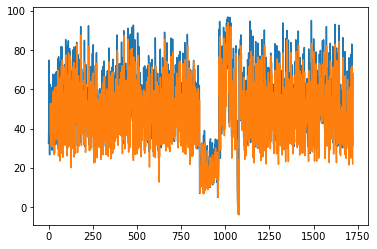

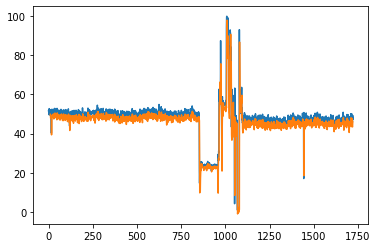

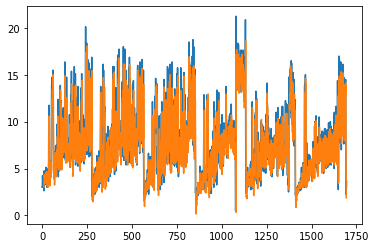

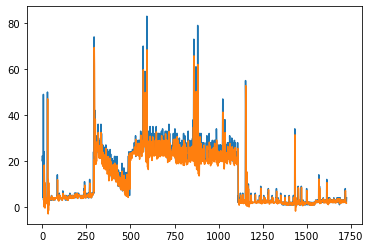

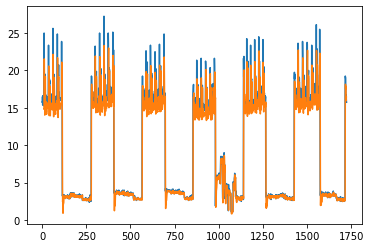

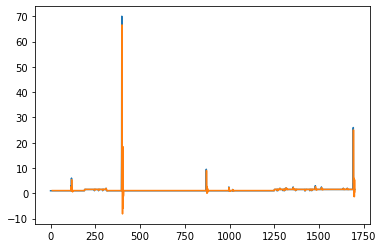

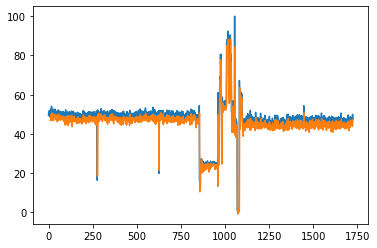

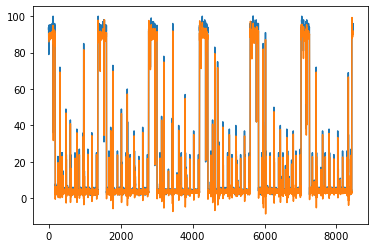

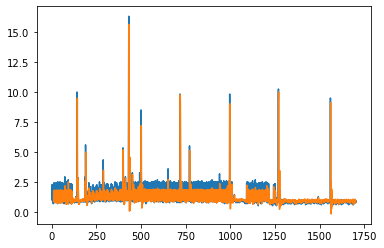

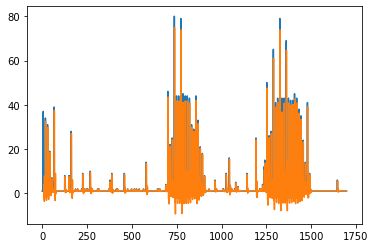

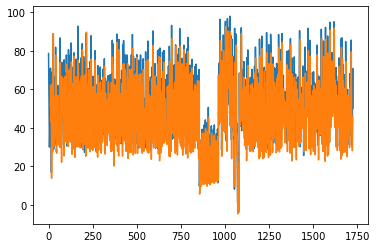

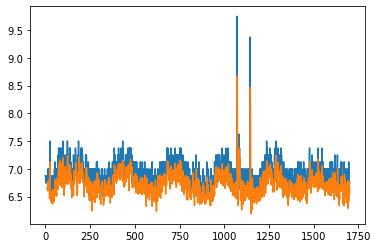

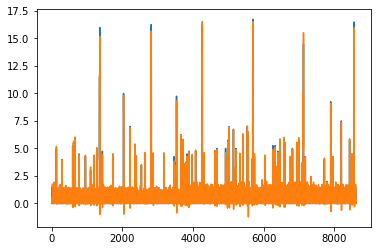

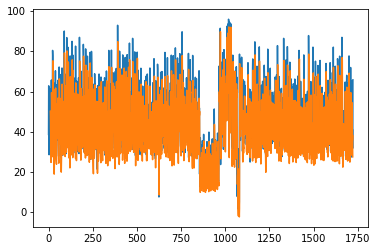

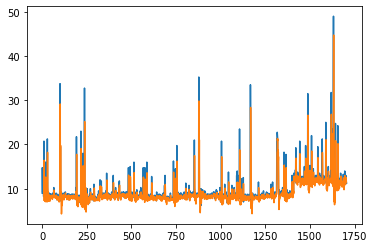

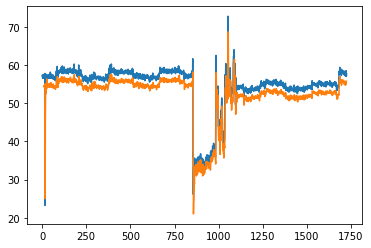

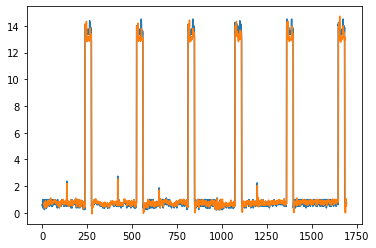

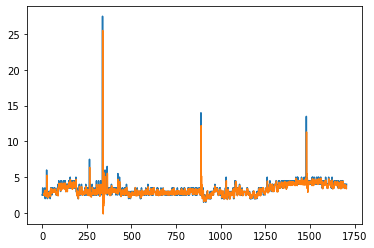

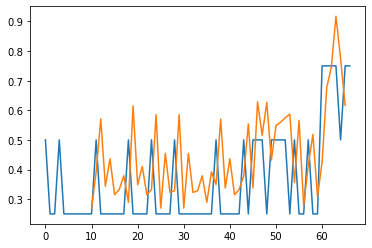

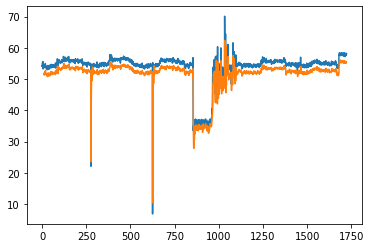

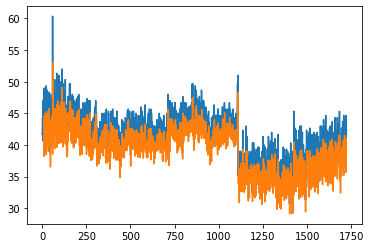

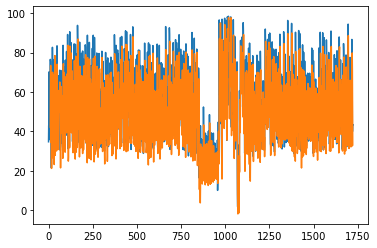

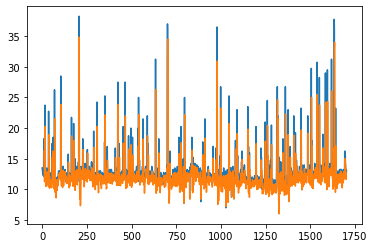

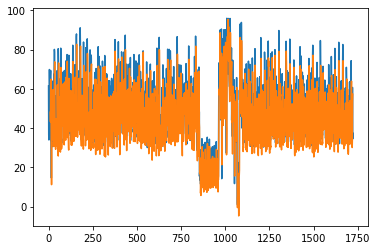

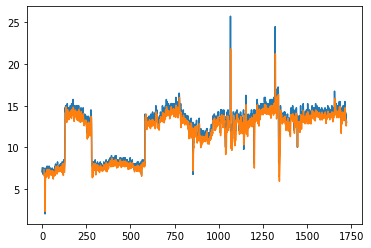

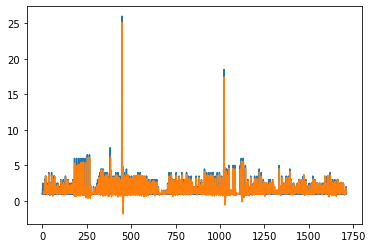

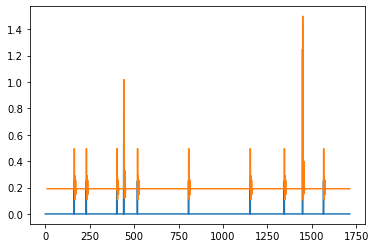

messages_unacknowledged


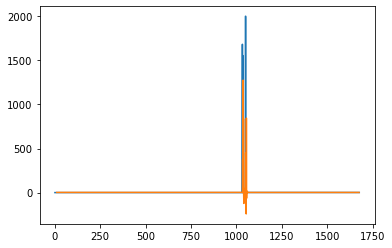

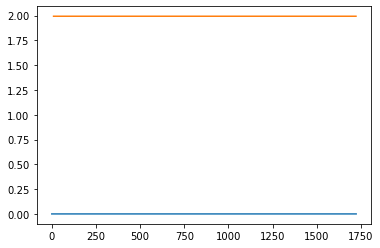

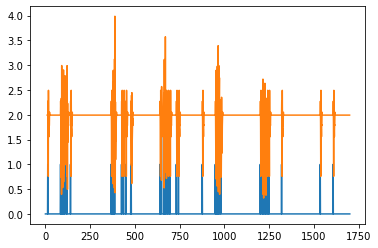

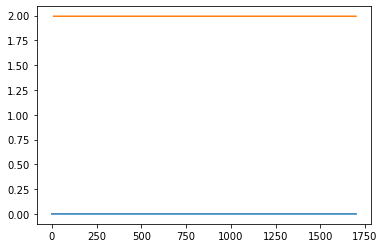

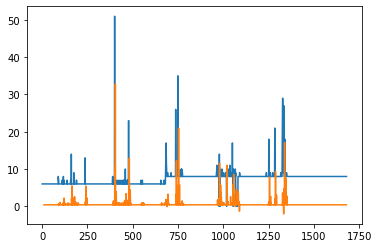

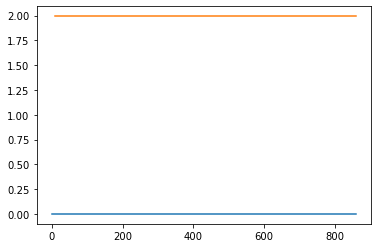

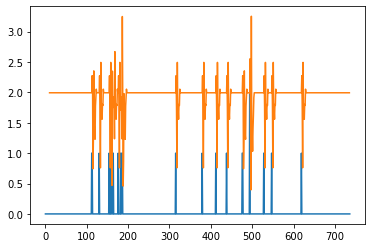

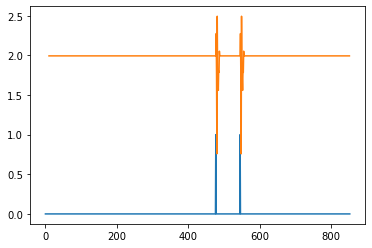

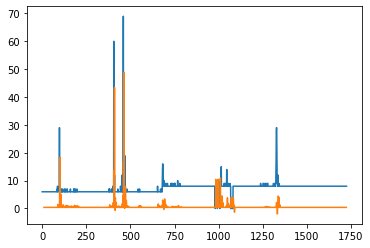

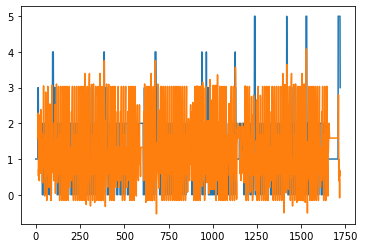

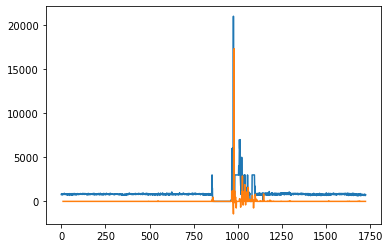

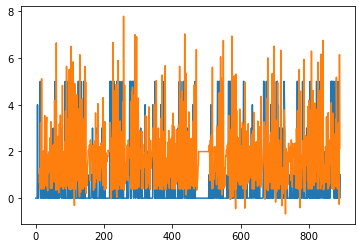

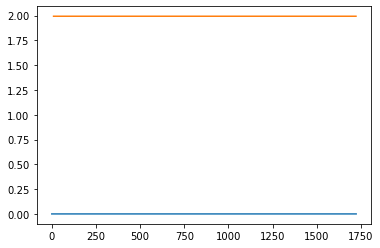

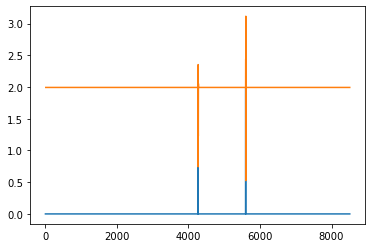

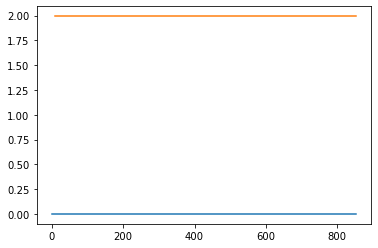

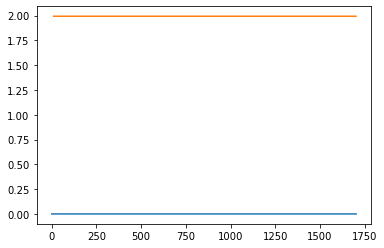

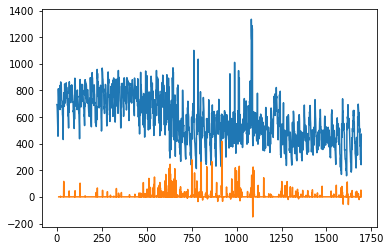

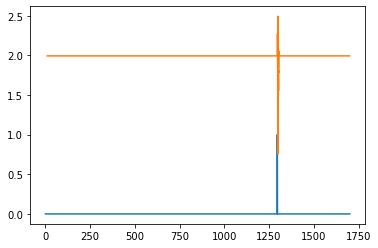

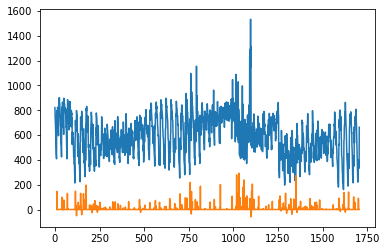

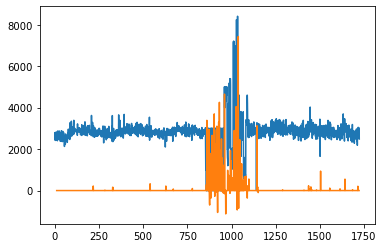

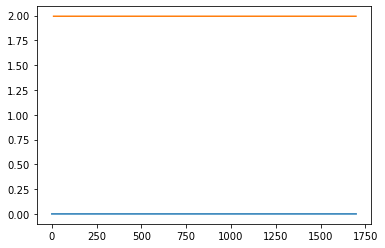

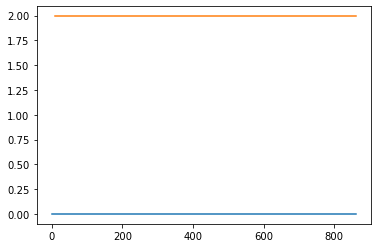

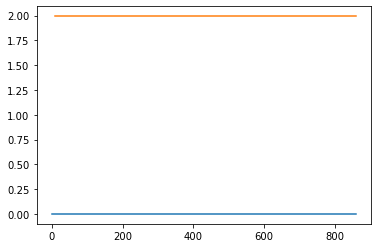

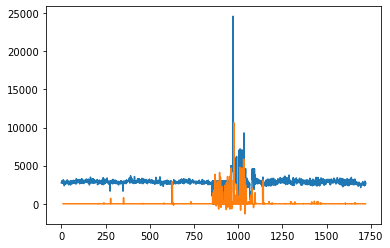

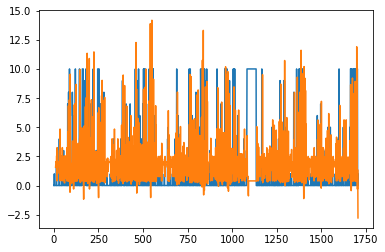

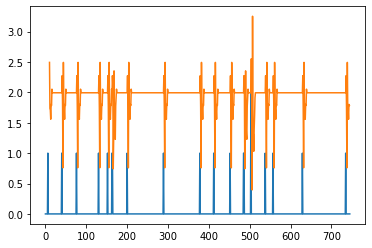

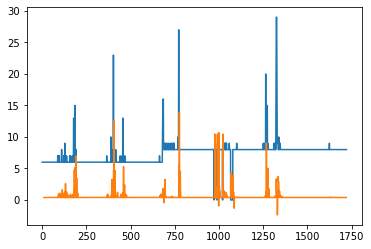

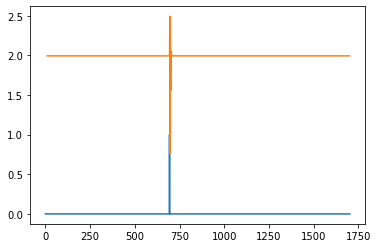

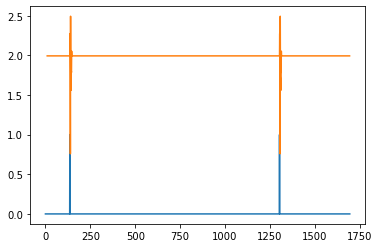

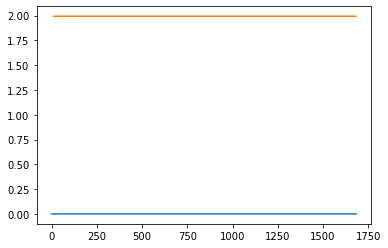

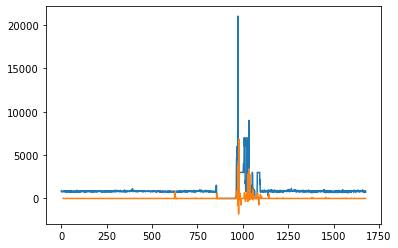

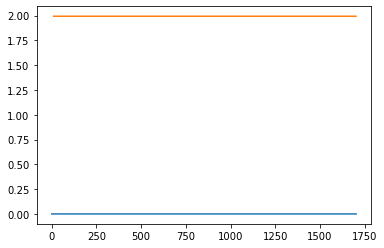

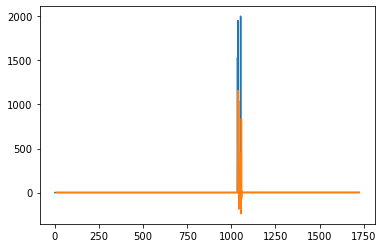

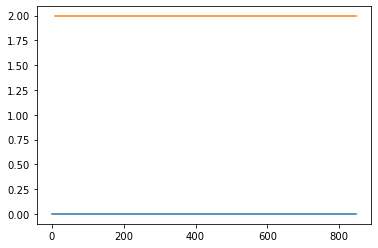

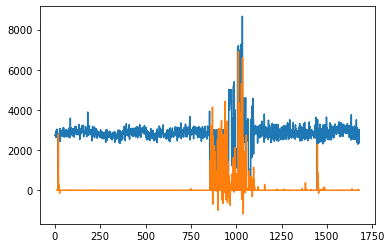

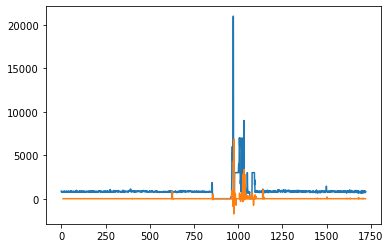

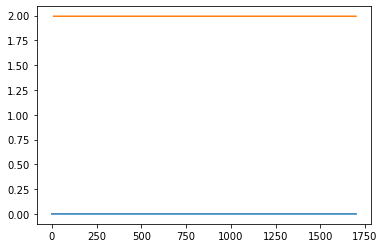

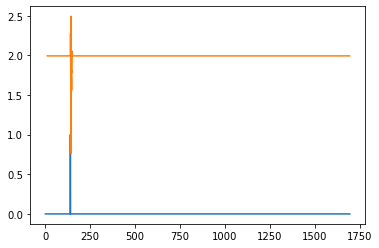

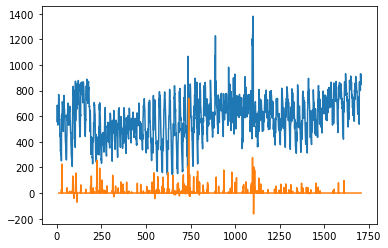

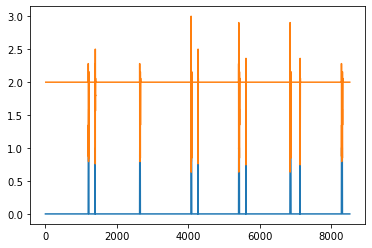

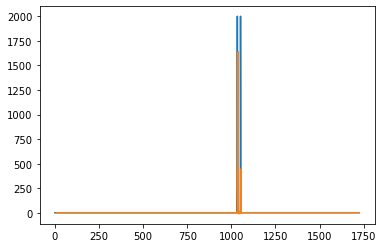

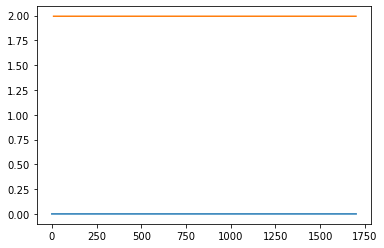

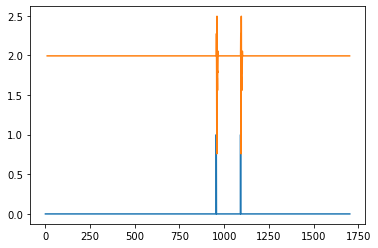

messages


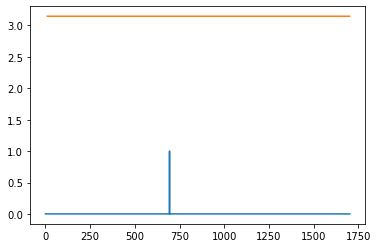

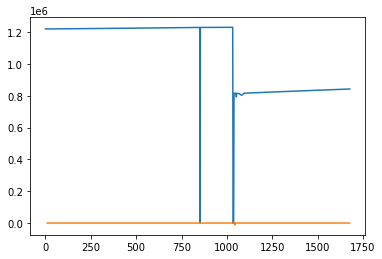

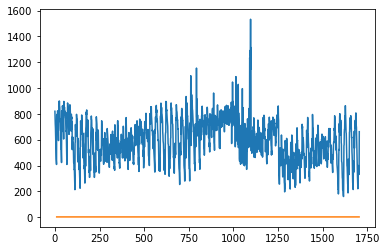

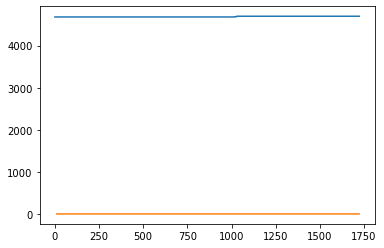

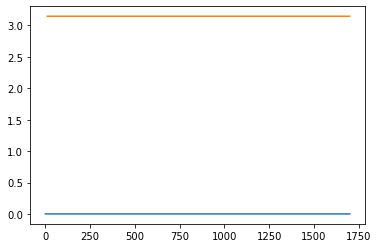

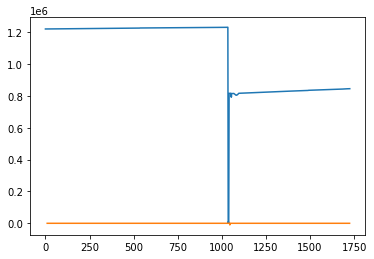

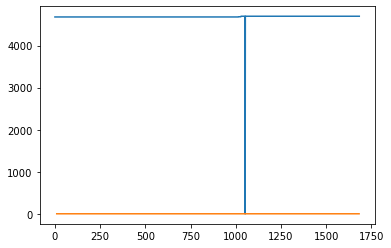

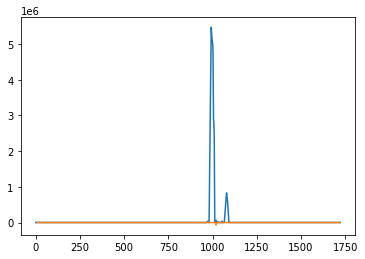

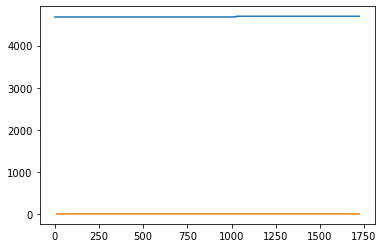

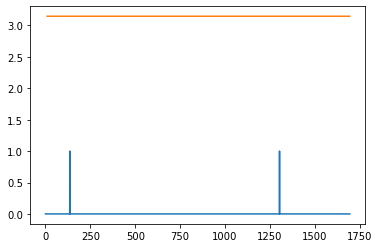

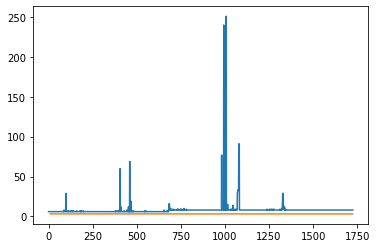

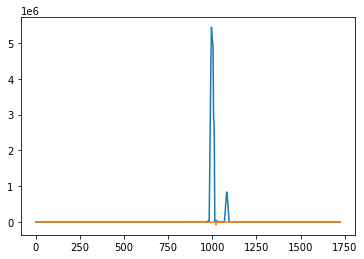

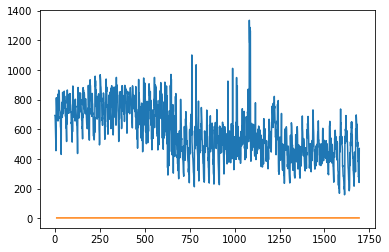

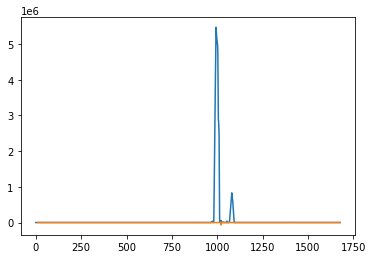

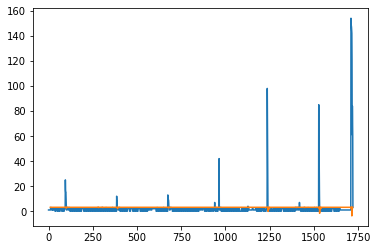

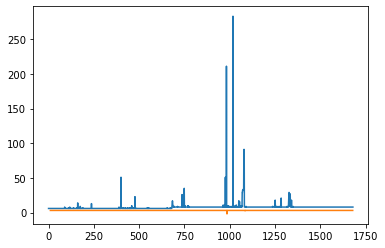

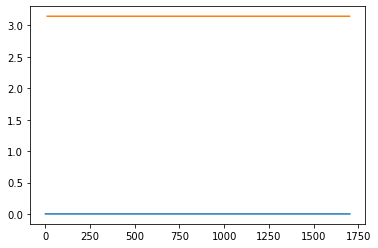

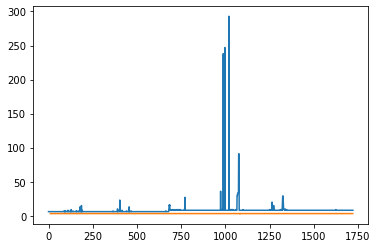

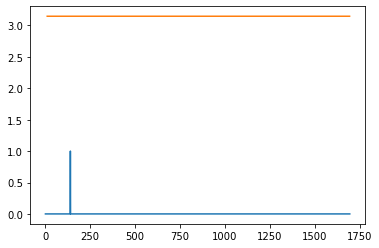

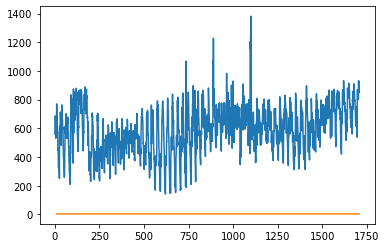

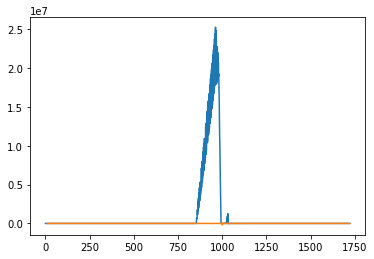

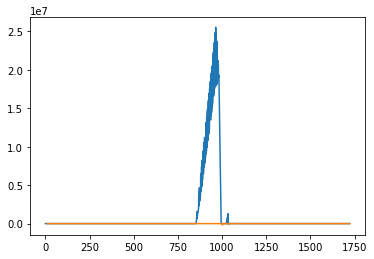

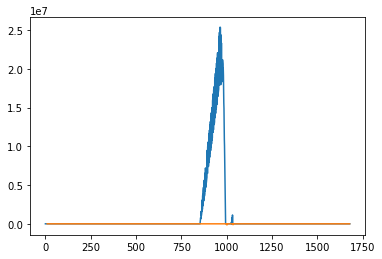

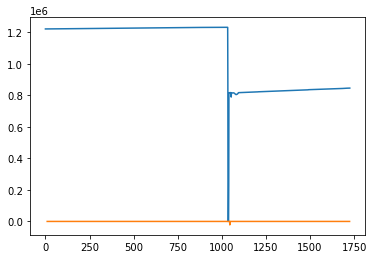

cpu_usage


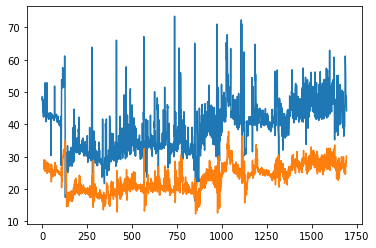

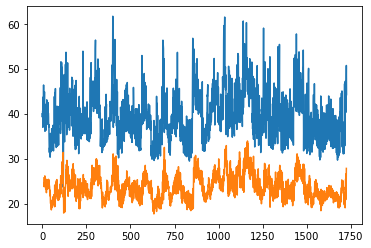

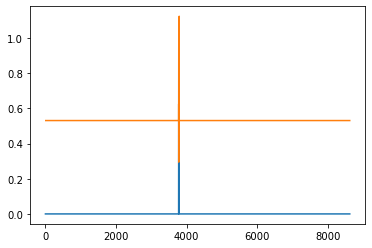

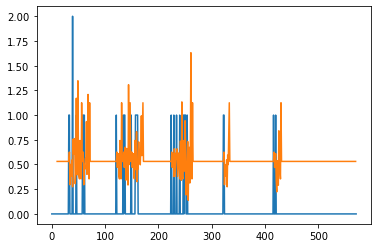

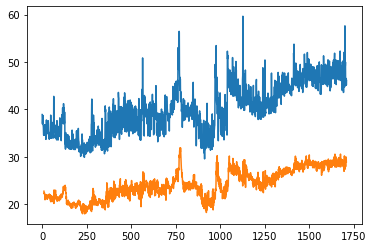

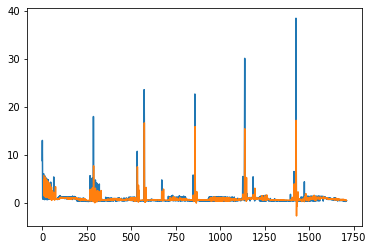

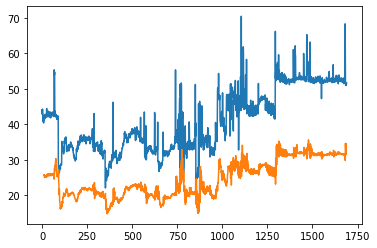

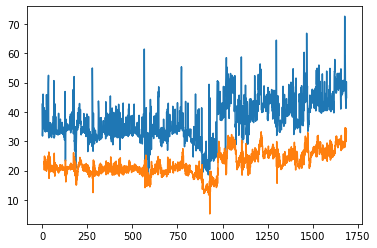

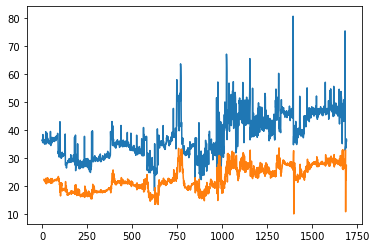

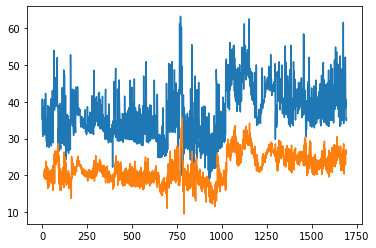

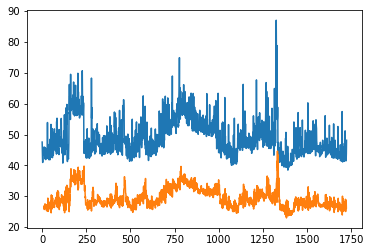

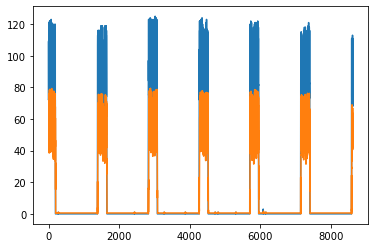

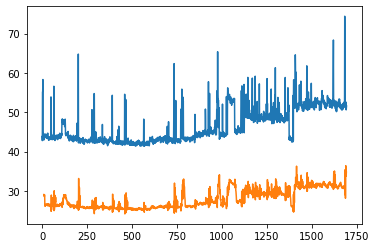

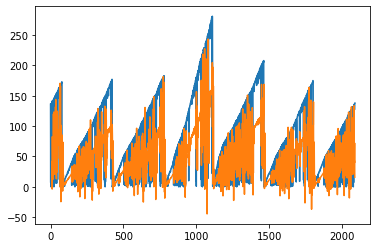

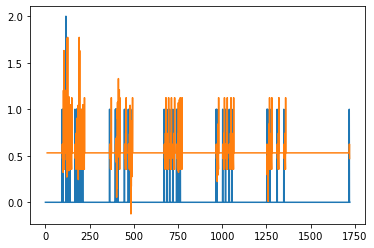

consumers


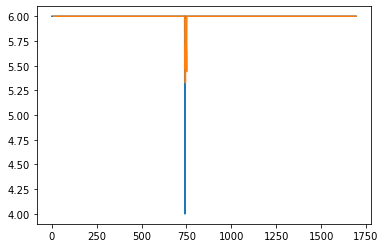

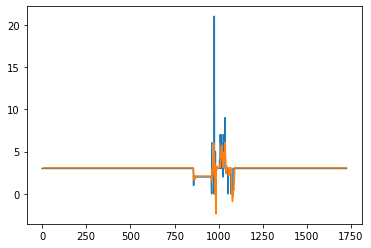

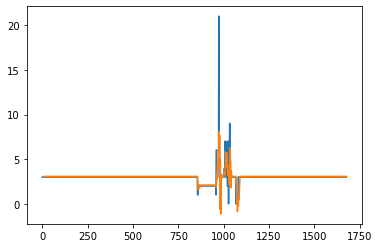

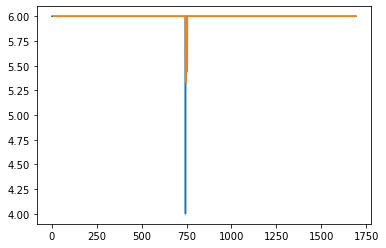

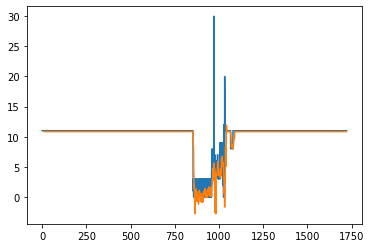

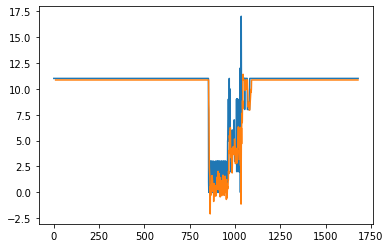

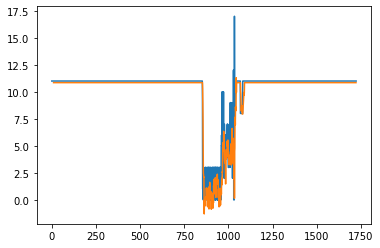

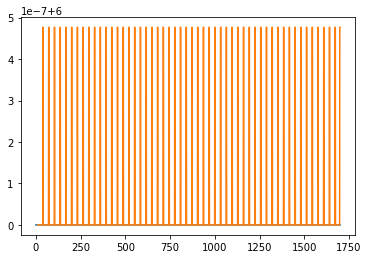

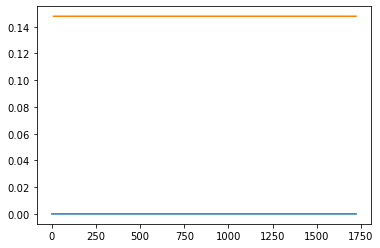

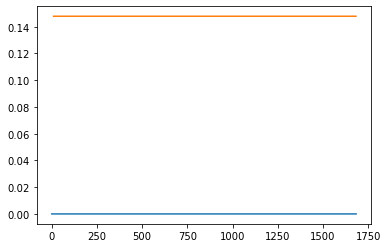

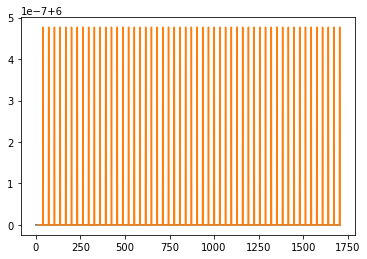

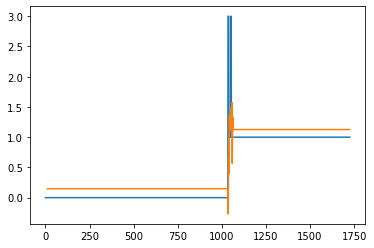

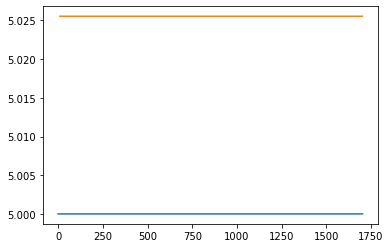

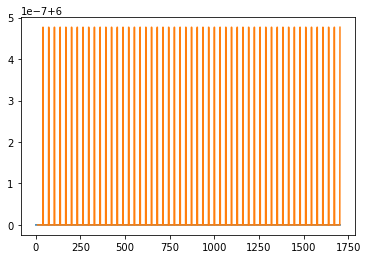

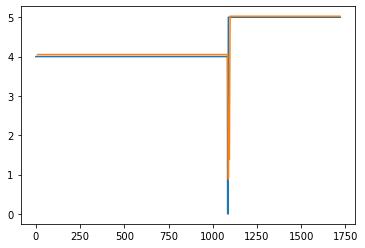

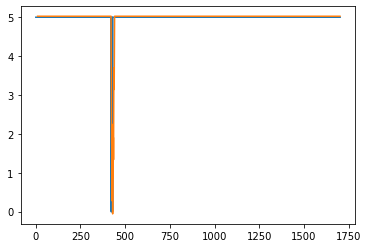

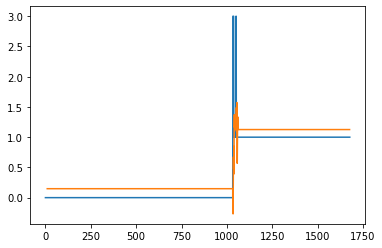

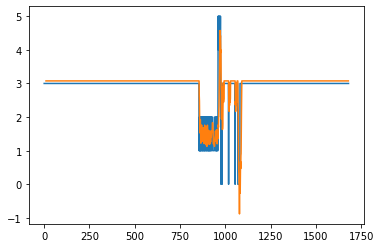

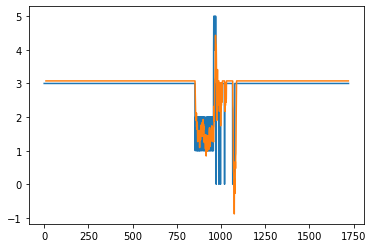

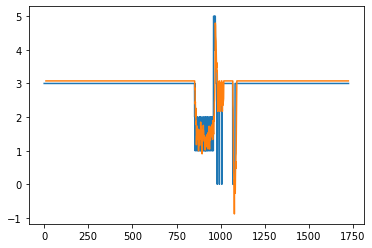

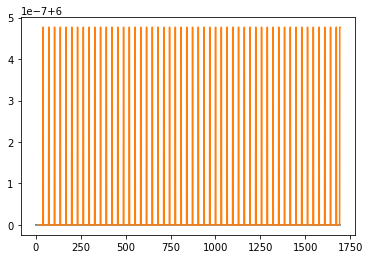

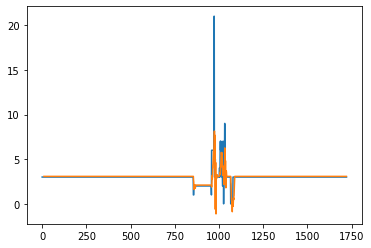

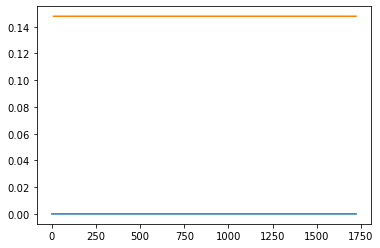

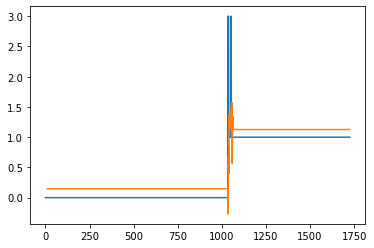

ack


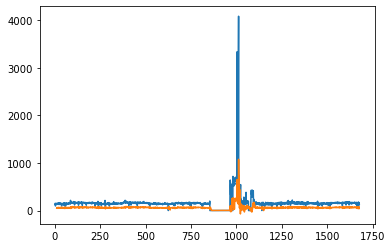

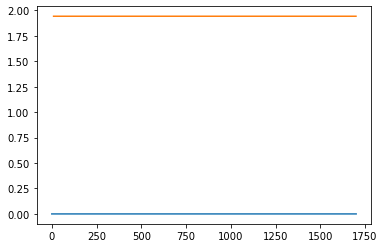

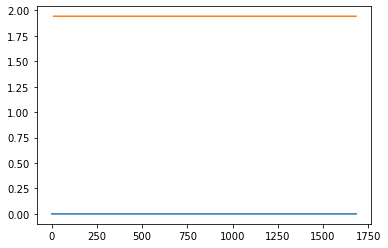

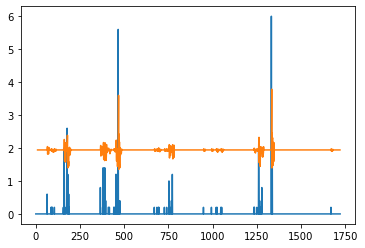

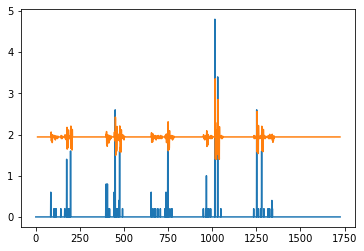

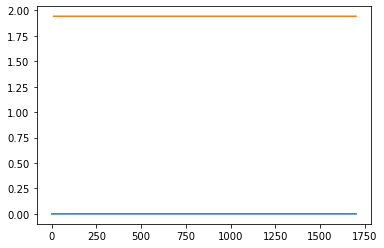

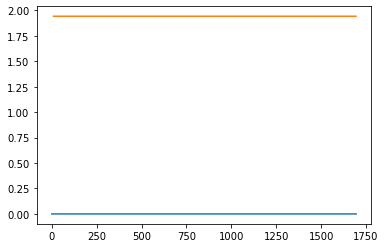

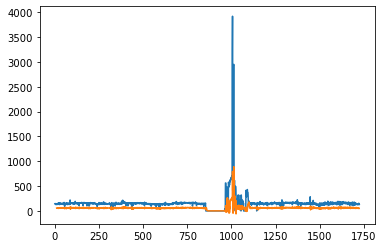

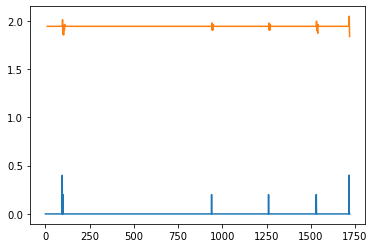

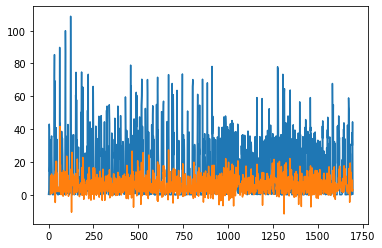

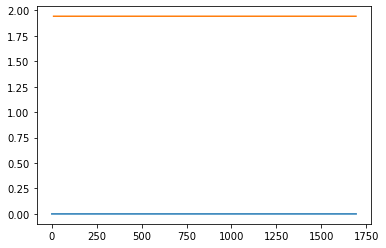

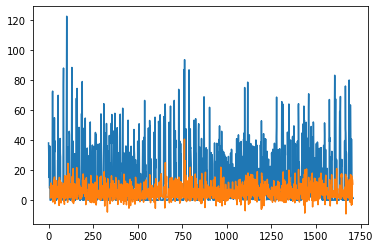

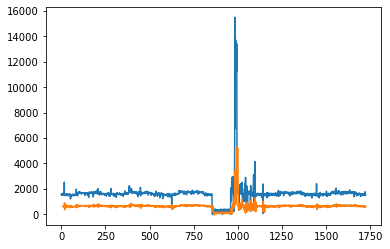

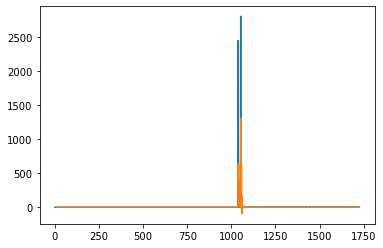

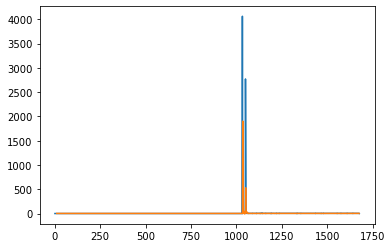

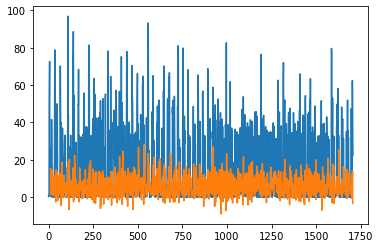

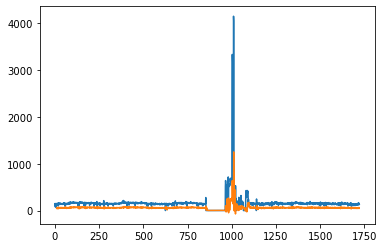

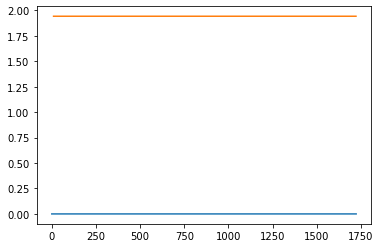

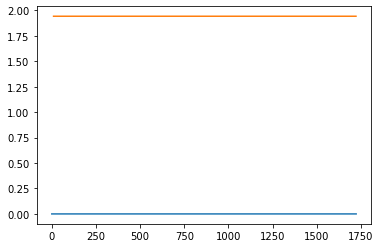

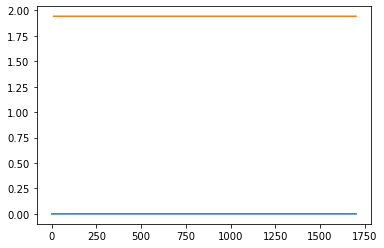

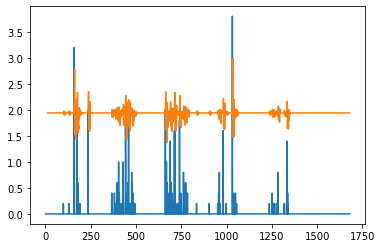

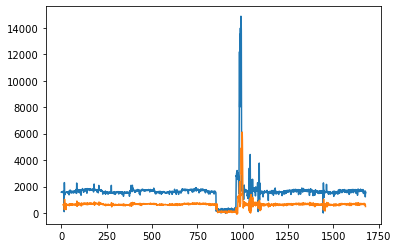

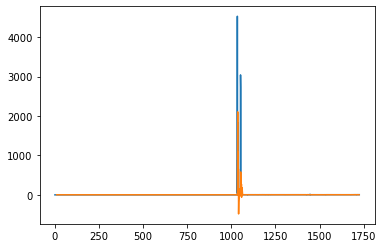

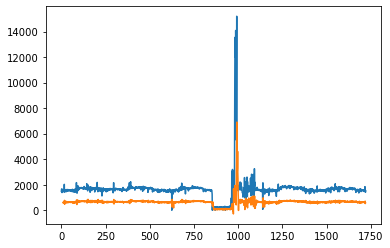

messages_ready


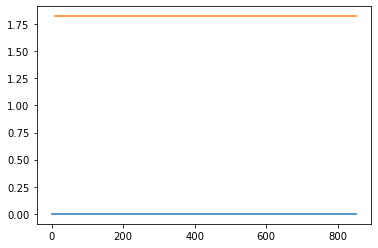

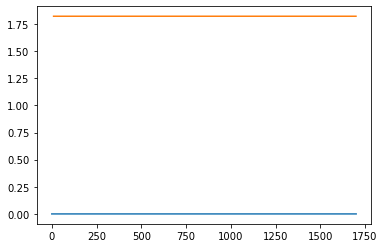

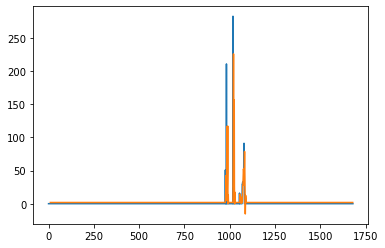

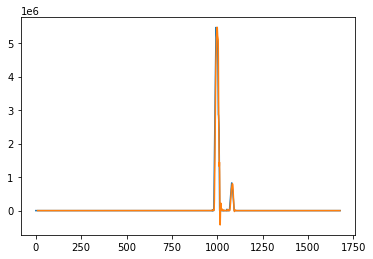

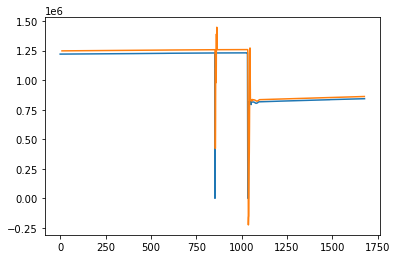

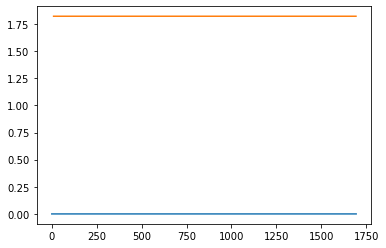

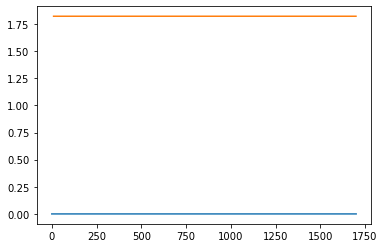

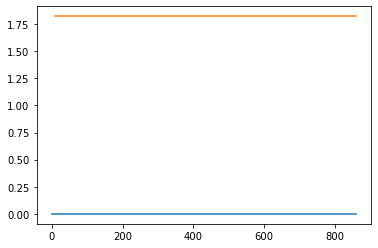

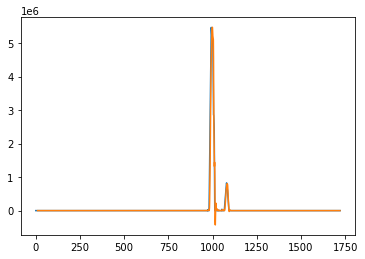

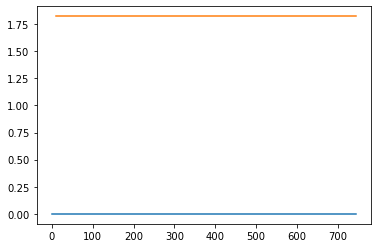

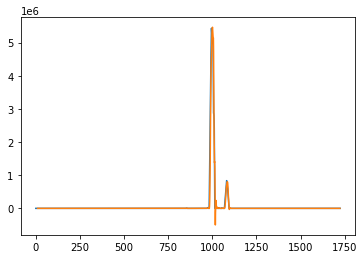

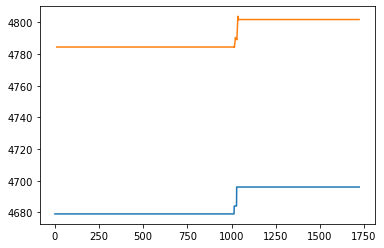

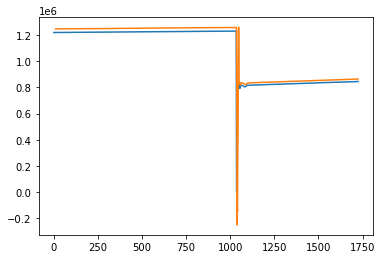

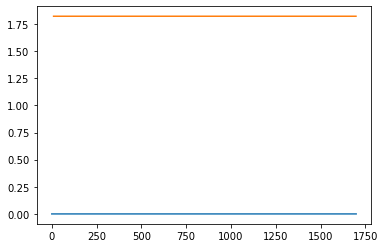

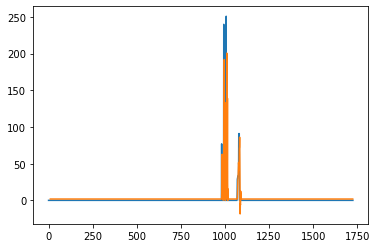

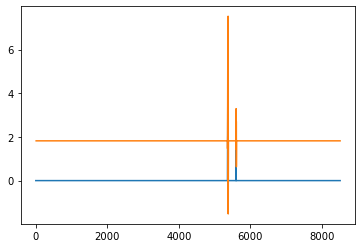

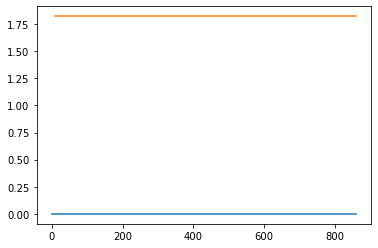

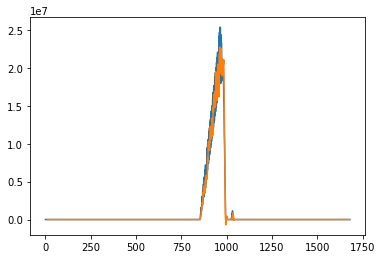

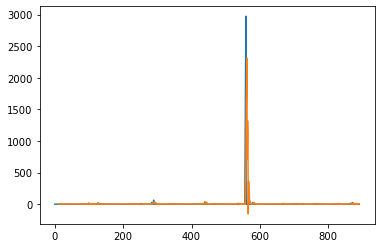

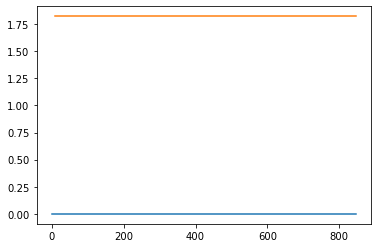

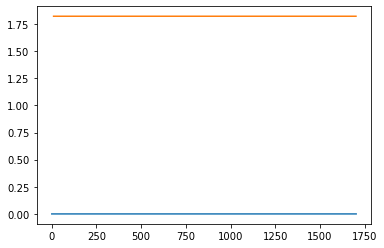

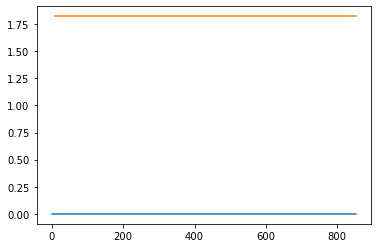

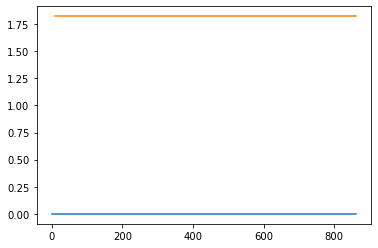

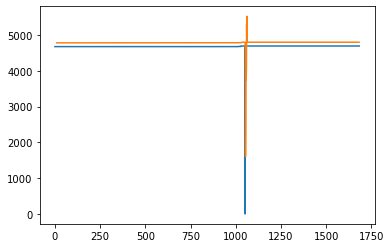

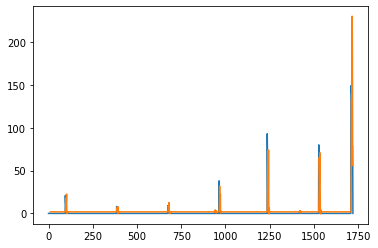

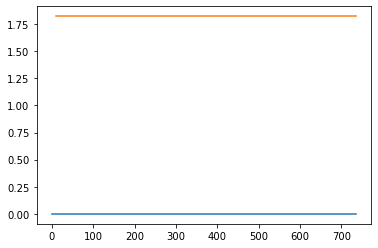

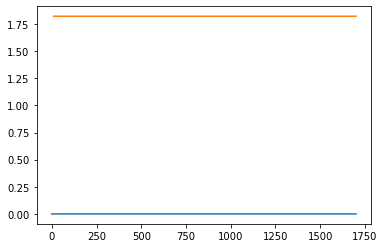

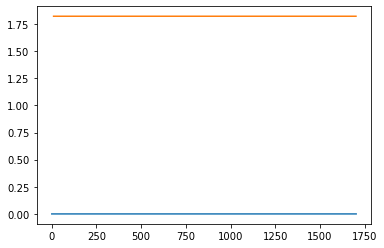

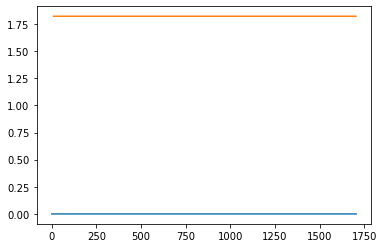

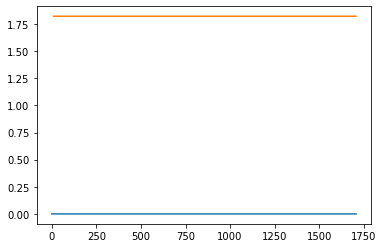

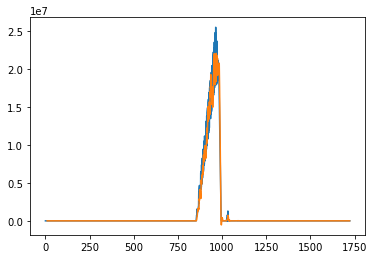

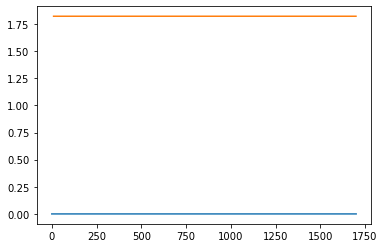

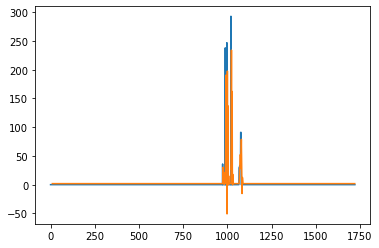

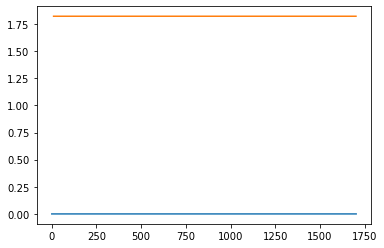

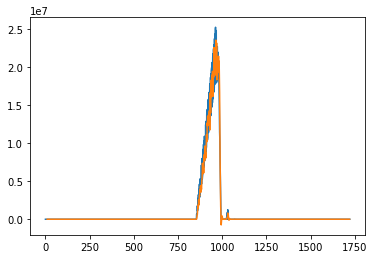

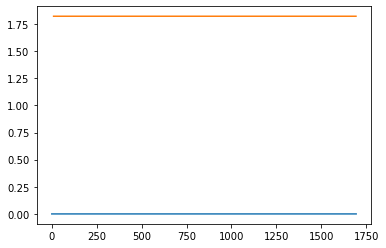

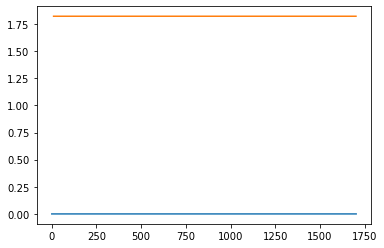

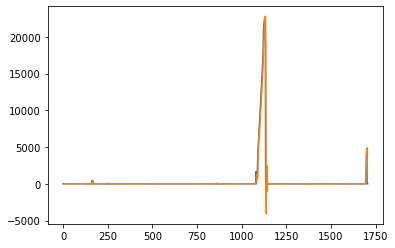

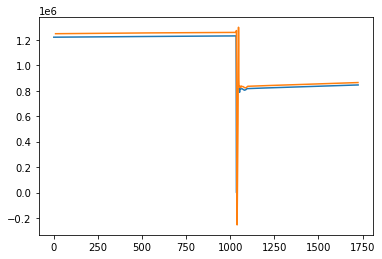

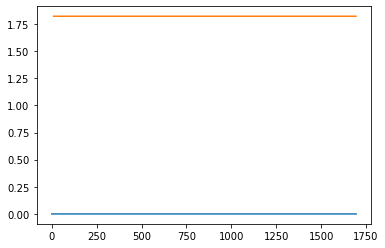

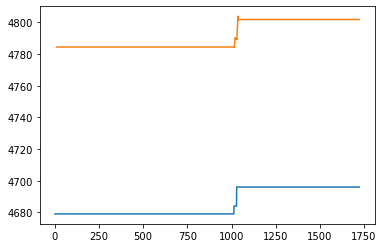

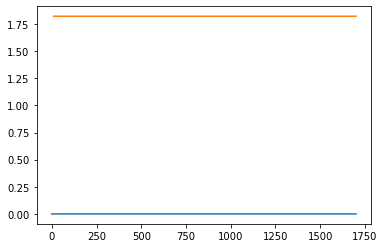

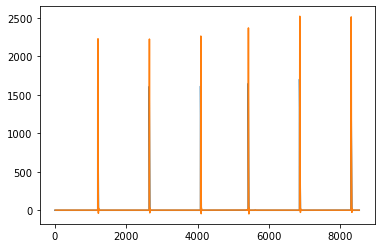

memoryConsumed


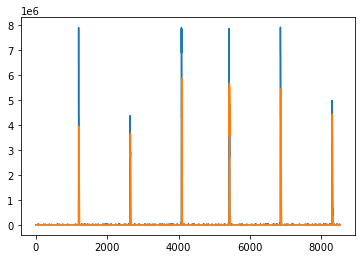

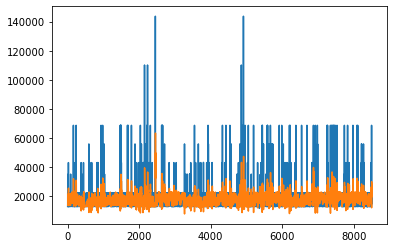

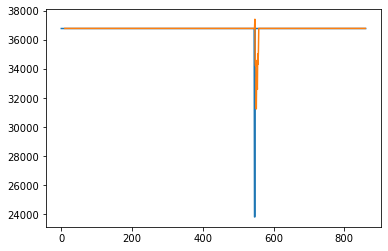

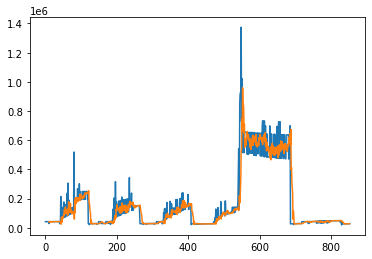

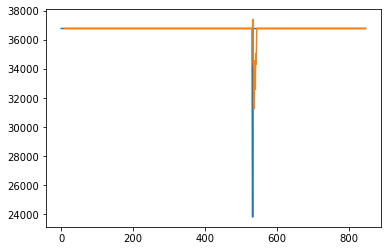

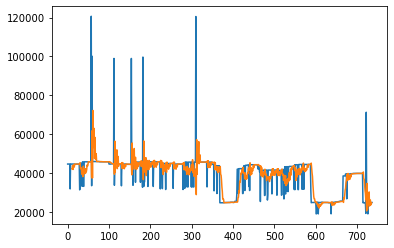

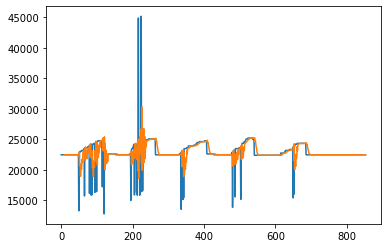

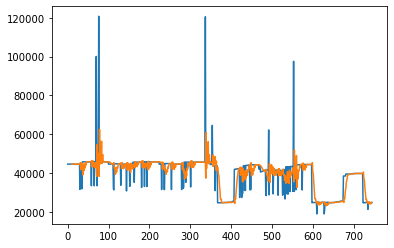

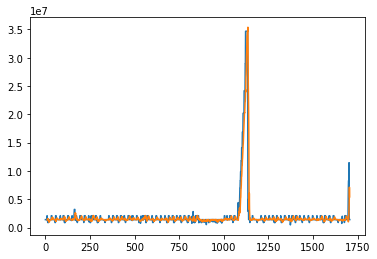

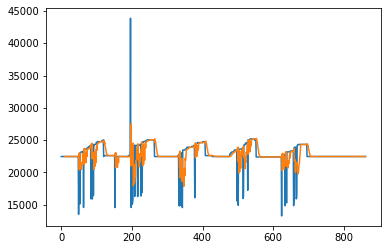

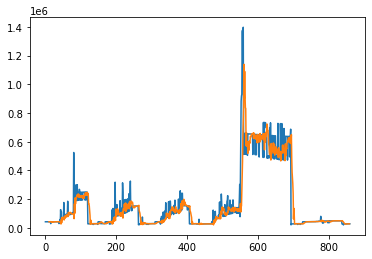

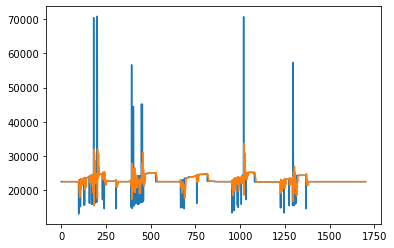

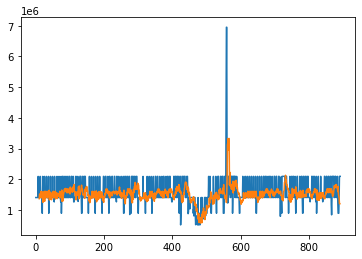

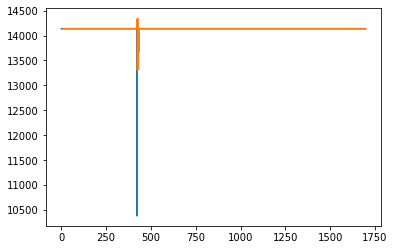

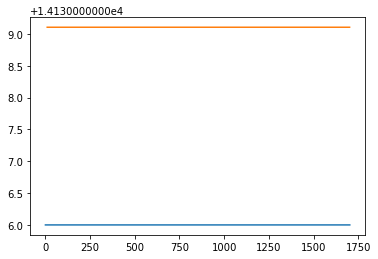

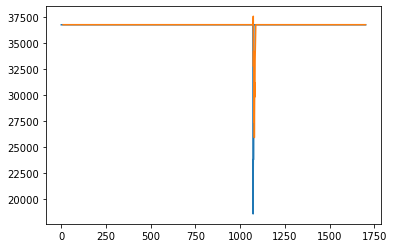

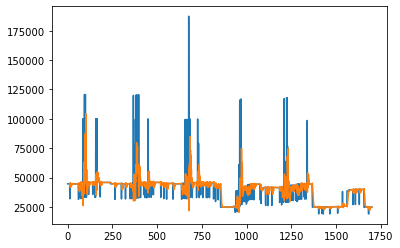

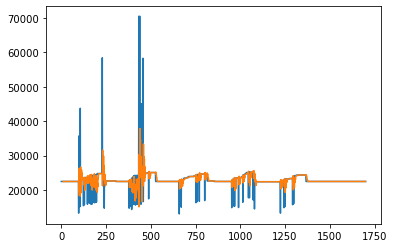

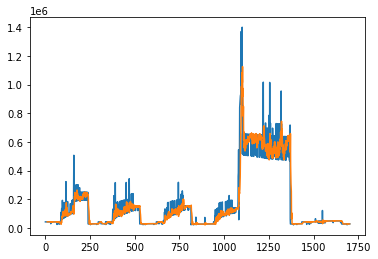

cpu


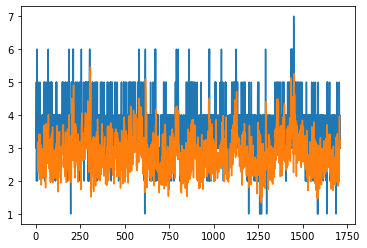

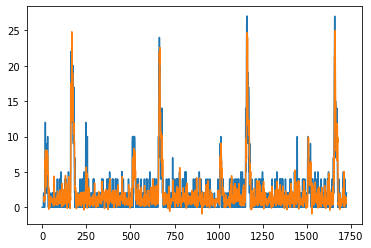

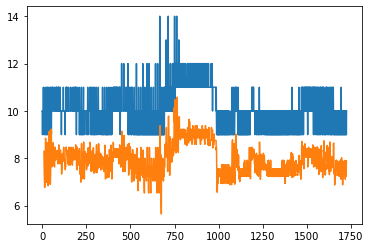

cpu_ready


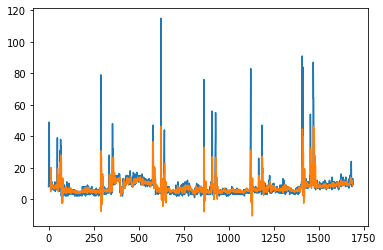

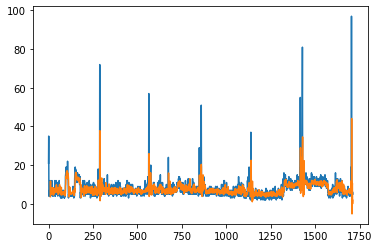

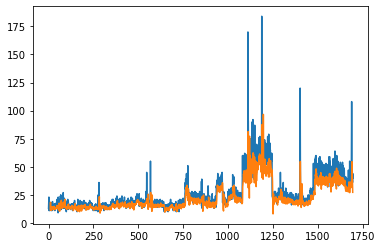

cpu_wait


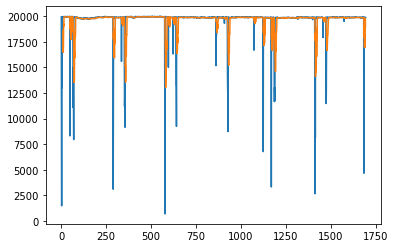

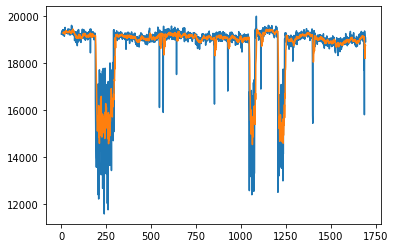

In [5]:
for indx in keys_name:
    indexOpt = dicOpt[indx]
    name = dnn_data.iloc[indexOpt].loc[:,'metric_id'].values
    indexNames = ts_data[ ts_data['metric_id'] == name[0] ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
    dataset = data.values
    dataset = dataset.astype('float32')
    dataset = dataset.reshape(-1,1)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 10
    x_train, y_train = create_dataset(train, look_back)
    x_valid, y_valid = create_dataset(test, look_back)

    model=Sequential()
    model.add(Dense(units=32, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    
    start_fit = time.time()
    model.fit(x_train,y_train, epochs=100, batch_size=30, verbose=0, validation_data=(x_valid,y_valid), shuffle=False)
    end_fit = time.time()
    
    print(indx)
    for indx_id in dic_name[indx]:
        indexNames = ts_data[ ts_data['metric_id'] == indx_id ].index
        data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
        dataset = data.values
        dataset = dataset.astype('float32')
        dataset = dataset.reshape(-1, 1)
        X, Y = create_dataset(dataset[:,:], look_back)
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        start = time.time()
        prediction = model.predict(X)
        end = time.time()
        err = math.sqrt(mean_squared_error(Y, prediction[:,0]))
        dic_id[indx_id].append(err) 
        dic_id[indx_id].append(end_fit - start_fit) 
        dic_id[indx_id].append(end - start) 
        fig, ax = plt.subplots()
        # shift predictions for plotting
        trainPlot = np.empty_like(dataset)
        trainPlot[:,:] = np.nan
        trainPlot[look_back:len(dataset)-1, :] = prediction.reshape(-1,1)
        # plot baseline and predictions
        ax.plot(dataset)
        ax.plot(trainPlot)
    plt.show()

In [6]:
pd.DataFrame(dic_id).to_csv('DNN_name_bis.csv', encoding='utf-8')